In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import statsmodels.api as sm
import warnings
from astropy.io import fits

%matplotlib inline

## Functions

In [38]:
def linear_f(x, m, b):
    return m*x+b

def fits_f(x_data, y_data, estimate):
    """
    Fit a linear model to the provided data using curve_fit from scipy.optimize.

    Parameters:
    x_data (array-like): Independent variable data.
    y_data (array-like): Dependent variable data.
    estimate (list): Initial guess for the parameters of the linear model [slope, intercept].

    Returns:
    x_fits (array): Independent variable values for the fitted line.
    y_fits (array): Dependent variable values for the fitted line.
    [m, b] (list): Fitted parameters, where m is the slope and b is the intercept of the linear model.
    """
    # Use curve_fit function from scipy.optimize to fit data to a linear function
    popt, pcov = curve_fit(linear_f, x_data, y_data, p0=estimate)
    m, b = popt

    # Generate x and y values for best fit line.
    x_min = x_data.min()
    x_max = x_data.max()
    x_fits = np.linspace(x_min-0.1*np.abs(x_min), x_max+0.1*np.abs(x_max), 1000)
    y_fits = linear_f(x_fits, m, b)

    return x_fits, y_fits, [m, b]

def plot_confidence_interval(x_data, y_data, label, color=None):
    """
    Plots a confidence interval for a linear regression model. This is used to calculate the uncertainty in slope
    and y-intercept.

    Args:
        x_data (array-like): Independent variable data.
        y_data (array-like): Dependent variable data.
        label (str): Label for the confidence interval plot.
        color (str): Colour for the confidence interval plot.

    Returns:
        Tuple[float, float]: The uncertainty in the slope (m_unc) and intercept (b_unc) of the regression line.
    """
    # Find the minimum and maximum x values in the data. Then add a constant term to the x_data for regression
    x_min = x_data.min()
    x_max = x_data.max()
    x_with_const = sm.add_constant(x_data)
    
    # Generate a range of x values for the confidence interval
    x_linspace = np.linspace(x_min-0.1*np.abs(x_min), x_max+0.1*np.abs(x_max), 500)
    x_linspace_with_const = sm.add_constant(x_linspace)
    
    # Fit a linear regression model to the data
    model_ci = sm.OLS(y_data, x_with_const).fit()
    
    # Get predictions and confidence intervals for the regression. Snake_case "ci" for confidence interval"
    predictions_ci = model_ci.get_prediction(x_linspace_with_const)
    conf_interval = predictions_ci.conf_int()
    lower_bound_ci = conf_interval[:, 0]
    upper_bound_ci = conf_interval[:, 1]
    
    # Plot the confidence interval
    ax.fill_between(x_linspace, lower_bound_ci, upper_bound_ci, color=color, alpha=0.1, label=label)
    
    # Calculate uncertainty in slope and intercept. Snake_case "lb" for lower bound; "ub" for upper bound.
    # These are points on the confidence intervals used to calculate uncertainty bounds.
    point1 = [x_linspace[0], lower_bound_ci[0]]
    point2 = [x_linspace[-1], upper_bound_ci[-1]]
    point3 = [x_linspace[0], upper_bound_ci[0]]
    point4 = [x_linspace[-1], lower_bound_ci[-1]]
    
    slope_lb = (lower_bound_ci[-1] - upper_bound_ci[0]) / (x_linspace[-1] - x_linspace[0])
    slope_ub = (upper_bound_ci[-1] - lower_bound_ci[0]) / (x_linspace[-1] - x_linspace[0])
    slope_uncertainty = np.abs(slope_lb - slope_ub) / 2
    
    intercept_lb = point2[1] - slope_ub * point2[0]
    intercept_ub = point4[1] - slope_lb * point4[0]
    intercept_uncertainty = np.abs(intercept_lb - intercept_ub) / 2
    
    return slope_uncertainty, intercept_uncertainty

def z_to_d(z, z_err=0, units='Mpc'):
    """Converts redshift (z) to distance (d) in various units.
    Args:
        z (float): Redshift value.
        z_err (float): Error in redshift value (default is 0).
        units (str): Unit for the output distance ('ly', 'km', or 'Mpc', default is 'Mpc').

    Returns:
        tuple: A tuple containing the converted distance (d) and its error (d_err) in the specified units.
    """
    c = 299792458 * 1e-3  # Speed of light in km/s
    H_0 = 68.3  # Hubble's Constant in km/s/Mpc
    H_0_err = 1.5  # Hubble's Constant error in km/s/Mpc
    
    # Used when converting Mpc to other units
    conversion_factors = {
        'ly': 3.262e+6,
        'km': 3.086e+22,
        'Mpc': 1.0  
    }
    
    if units not in conversion_factors:
        raise ValueError("Not a valid unit. Try any of 'Mpc', 'ly', or 'km'.")
    
    conversion_factor = conversion_factors[units]
    d = c * z / H_0 * conversion_factor
    d_err = np.sqrt((z_err * c / H_0 * conversion_factor) ** 2 + (H_0_err * c * z / H_0 ** 2 * conversion_factor) ** 2)  # Errors of z and H_0 are treated independently.
    
    return d, d_err

def apply_custom_style(title, xlabel, ylabel, style=1, x_data=None, y_data=None):
    """
    Apply a custom style to a Matplotlib plot.
    """
    if style == 1:
        # Set the ticks
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        
        plt.title(title, fontsize=16)
        plt.xlabel(xlabel, fontsize=14)
        plt.ylabel(ylabel, fontsize=14)
        plt.legend(fontsize=12, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)

        # Add gridlines
        plt.grid(True, linestyle='--', alpha=0.6) # major gridlines
        plt.minorticks_on()
        plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.1) # minor gridlines
        
        if x_data is not None:
            xlim_min = x_data.min()-0.02*np.abs(x_data.min())
            xlim_max = x_data.max()+0.02*np.abs(x_data.max())
            ax.set_xlim(xlim_min, xlim_max)  
            
            if all(x <= 0 for x in x_data):
                plt.gca().invert_xaxis()
            
        if y_data is not None:    
            ylim_min = y_data.min()-0.02*np.abs(y_data.min())
            ylim_max = y_data.max()+0.02*np.abs(y_data.max())
            ax.set_ylim(ylim_min, ylim_max)
        
        plt.tight_layout()  # Ensure proper spacing between subplots
    else:
        warnings.warn(f"Style = {style} is not an option. Choosing default style = 1.", UserWarning)
        style = 1
        
    

def plot_features(x_data, y_data, group_col=None, best_fit=True, cinterval=True, residuals=True):
    """
    Generate scatter plots with colored data points and best fit lines for unique values in a mask column.
    Features include
        - scatter plot of x_data and y_data
        - line of best fit
        - 95% confidence interval of linear regression.

    Parameters:
    - x_data (array-like): X-axis data.
    - y_data (array-like): Y-axis data.
    - mask_col (array-like, optional): Column to group data by unique values.
    - best_fit (boolean, optional): True to display best fit line. False otherwise. Defaults True.
    - cinterval (boolean, optional): True to display 95% confidence interval. False otherwise. Defaults True.
    - cinterval (boolean, optional): True to return residuals of best fit line. False otherwise. Defaults True.
    """
    values = group_col.unique()
    colors = ['b', 'r', 'g', 'purple', 'orange']
    residuals_dict = {}
    
    for i, value in enumerate(values):
        mask = group_col == value # This mask is used to filter out certain data to create groups.
        count = sum(mask)
        plt.scatter(x_data[mask], y_data[mask], s=20, color=colors[i], alpha=0.4, edgecolors='k', linewidths=0.5, label=f'{value} (N={count})')
        
        # Plot the confidence interval
        if cinterval == True:
            # Fit the data for TYPE == 0 and plot the confidence interval
            m_unc, b_unc = plot_confidence_interval(x_data[mask], y_data[mask], f'95% Confidence Interval ({value})', color=colors[i])
        
        # Fit the data and plot the best fit line
        if best_fit == True:
            x_fit, y_fit, opt = fits_f(x_data[mask], y_data[mask], [1, 4])
            plt.plot(x_fit, y_fit, label=f'Line of Best Fit ({value}):\n $y=({opt[0]:.2f}\pm{m_unc:.2f})x+({opt[1]:.2f}\pm{b_unc:.2f})$', color=colors[i], linestyle='--')
        
        if residuals == True:
            residual_y = y_data[mask] - linear_f(x_data[mask], opt[0], opt[1])
            residual_x = x_data[mask]
            residuals_dict[value] = [residual_x, residual_y]
    
    return residuals_dict

def plot_residuals(residuals, xlabel, ylabel, filename):
    """
    Display residual plots using a dictionary of residuals.

    Parameters:
    - residuals (dict): A dictionary where keys represent plot labels, and values are 2D arrays of residual data.
    - xlabel (str): Label for the x-axis of the residual plots.
    - ylabel (str): Label for the y-axis of the residual plots.
    - filename (str): File to save plot to (without file extension)
    """
    colors = ['b', 'r', 'g', 'purple', 'orange']
    num_plots = len(residuals)
    
    # Iterate through the residuals dictionary
    for i, (key, values) in enumerate(residuals.items()):
        residuals_x = values[0]
        residuals_y = values[1]
        
        # Calculate residual statistics
        mean_res = np.mean(residuals_y)
        max_res = np.max(residuals_y)
        min_res = np.min(residuals_y)
        
        # Create a subplot for each set of residuals
        plt.subplot(num_plots, 1, i+1)  # Create the top subplot
        plt.scatter(residuals_x, residuals_y, s=20, color=colors[i], alpha=0.6, edgecolors='k', linewidths=0.5)
        plt.axhline(0, color='k', linestyle='--', linewidth=0.8)
        plt.title(f'Residual Plot for ({key})', fontsize=14)
        plt.xlabel(xlabel, fontsize=12)
        plt.ylabel('Residuals of ' + ylabel, fontsize=9)
        
        # Add residual statistics to the legend
        plt.legend([f"Mean: {mean_res:.2f}\nMax: {max_res:.2f}\nMin: {min_res:.2f}"],
           bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., fontsize=12, handlelength=0)
        
        # Add gridlines
        plt.grid(True, linestyle='--', alpha=0.6) # major gridlines
        plt.minorticks_on()
        plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.1) # minor gridlines
               
    plt.tight_layout()  # Ensure proper spacing between subplots
    
    plt.savefig(f'plots/{filename}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
def clean_df(df, x_data=None, y_data=None):
    # Delete NaN Values.
    df = df[pd.notna(x_data) & pd.notna(y_data)]
    
    # Add Distance Column
    d, d_err = z_to_d(df['z_spec'], units='Mpc')
    df['D'] = d
    df['D_err'] = d_err
    return df

def plot_fitlines(x_data, y_data, i=None, color=None, label=None, best_fit=True, cinterval=True, residuals=True):
    """
    Generate scatter plots with colored data points and best fit lines for unique values in a mask column.
    Features include
        - scatter plot of x_data and y_data
        - line of best fit
        - 95% confidence interval of linear regression.
    """
    count = len(x_data)
    ax.scatter(x_data, y_data, s=20, color=color, alpha=0.4, edgecolors='k', linewidths=0.5, label=f'{label} (N={count})')

    # Plot the confidence interval
    if cinterval == True:
        # Fit the data for TYPE == 0 and plot the confidence interval
        m_unc, b_unc = plot_confidence_interval(x_data, y_data, f'95% Confidence Interval ({label})', color=color)

    # Fit the data and plot the best fit line
    if best_fit == True:
        x_fit, y_fit, fit_params = fits_f(x_data, y_data, [1, 4])
        ax.plot(x_fit, y_fit, label=f'Line of Best Fit ({label}):\n $y=({fit_params[0]:.2f}\pm{m_unc:.2f})x+({fit_params[1]:.2f}\pm{b_unc:.2f})$', color=color, linestyle='--')
    
    return fit_params

def plot_residuals1(x_data, y_data, fit_params):
    residuals_x = x_data
    residuals_y = y_data - linear_f(x_data, fit_params[0], fit_params[1])
    
    colors = ['b', 'r', 'g', 'purple', 'orange']

    # Calculate residual statistics
    mean_res = np.mean(residuals_y)
    std_res = np.std(residuals_y)
    max_res = np.max(residuals_y)
    min_res = np.min(residuals_y)

    # Create a subplot for each set of residuals
    ax.scatter(residuals_x, residuals_y, s=20, color=colors[i], alpha=0.6, edgecolors='k', linewidths=0.5)
    ax.axhline(0, color='k', linestyle='--', linewidth=0.8)

    # Add residual statistics to the legend
    stats_text = f"Mean: {mean_res:.2f}\nStd: {std_res:.2f}\nMax: {max_res:.2f}\nMin: {min_res:.2f}"
    ax.text(1.02, 1.0, stats_text, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5, edgecolor='0.8'))
    

## SAMI Query

This is the query used to collect data from Data Central.

Data may be queried here: https://datacentral.org.au/services/query/ <br>
Data may be searched here: https://datacentral.org.au/services/schema/#sami


`SELECT 
    t1.CATID, t1.ellip, t1.z_spec, t1.Mstar, t1.M_r, t1.r_e,
    t2.VSIGMA_RE, t2.VSIGMA_RE_ERR, t2.SIGMA_RE, t2.SIGMA_RE_ERR, 
    t3.TYPE, 
    t4.Age_RE, t4.Age_RE_ERR, 
    t5.SFR_RE, t5.SFR_RE_ERR,
    t6.WARNSKER, t6.WARNZ, t6.ISBEST
FROM 
    sami_dr3.InputCatGAMADR3 as t1
JOIN 
    sami_dr3.samiDR3Stelkin as t2 ON t2.CATID = t1.CATID
JOIN 
    sami_dr3.VisualMorphologyDR3 as t3 ON t3.CATID = t1.CATID
JOIN 
    sami_dr3.SSPAperturesDR3 as t4 ON t4.CATID = t1.CATID
JOIN 
    sami_dr3.EmissionLine1compDR3 as t5 ON t5.CATID = t1.CATID
JOIN 
    sami_dr3.CubeObs as t6 ON t6.CATID = t1.CATID
WHERE 
    t3.TYPE IN (0, 0.5)
    AND t1.M_r > -100
    AND t2.SIGMA_RE > -100;`
    
For some reason, using WHERE NOT ( \_\_\_ IS NULL AND ___ IS NULL) doesn't work...

## Data Cleaning
- Only take values with error <5%?
- Delete duplicate rows
- Find a way to estimate M_r to get more data. Compare the accuracy. Maybe use .fits files if I can get the .tar.gz stuff to work.

Magnitude Filtering: Filtering galaxies by magnitude helps focus on galaxies that are bright enough to be well observed with the available instruments and resources.

Redshift Filtering: By selecting galaxies within a specific redshift range, astronomers can study objects at specific cosmic epochs and distances.
Also maybe choosing galaxies with low redshift space distortions.

Spectral Features: We might focus on galaxies that exhibit strong emission lines associated with specific elements or physical processes. This allows them to study phenomena such as star formation rates, chemical compositions, or the presence of active galactic nuclei.

### Note for Future:
- create a histogram showing how the number of galaxies change as we filter them out.

## Preliminary Data Cleaning for Faber-Jackson Relation Plotting

**Background:**
When obtaining data from DataCentral, we often encounter multiple CATIDs with varying values for the `AGE_RE` and `SFR_RE` columns. These columns are not essential for plotting the Faber-Jackson relation (FJR). Therefore, we follow these steps to clean the data:

1. **Drop Unnecessary Columns:** Initially, we eliminate the `AGE_RE` and `SFR_RE` columns since they are not utilized in FJR plotting. 


2. **Merge Identical Rows:** Subsequently, we merge rows with identical values, simplifying the dataset and avoiding redundancy.


3. **Handling Duplicate CATIDs:** In cases where there are duplicate CATIDs with different stellar kinematic information, we address this by dropping the duplicates from the dataframe.

This code is specifically designed for data preparation when plotting the Faber-Jackson relation, ensuring that the dataset is clean and ready for analysis.


In [80]:
# Drop the last 4 columns from original dataframe.
df = pd.read_csv('Query.csv')
df_dropped = df.iloc[:, :-4]

# Merge rows with identical values
df_merged = df_dropped.drop_duplicates(keep='first')

# Show rows with duplicate CATIDs and different values. Ideally, this should return an empty dataframe.
duplicate_rows = df_merged[df_merged.duplicated(subset=['CATID'], keep=False)]

# Find the CATIDs to delete and Filter out rows with CATIDs in catids_to_delete
catids_to_delete = duplicate_rows['CATID'].unique()
df_merged = df_merged[~df_merged['CATID'].isin(catids_to_delete)].reset_index(drop=True)
df_merged.to_csv('FJR.csv', index=False)
df_merged

,CATID,ellip,z_spec,Mstar,M_r,r_e,VSIGMA_RE,VSIGMA_RE_ERR,SIGMA_RE,SIGMA_RE_ERR,TYPE
0,7289,0.2661,0.08682,11.12,-22.370001,4.96,0.079767,0.007218,205.145279,1.877292,0.5
1,7839,0.2481,0.04749,11.05,-22.100000,6.95,0.320879,0.004302,195.761124,1.614042,0.5
2,7969,0.1772,0.08554,11.02,-22.120001,5.17,0.080168,0.006884,249.797653,2.451845,0.5
3,8488,0.0642,0.01996,9.51,-18.360001,1.42,NaN,NaN,74.450806,1.093145,0.0
4,8865,0.1000,0.07314,10.66,-21.160000,2.50,0.044664,0.009100,214.679764,2.817183,0.0
...,...,...,...,...,...,...,...,...,...,...,...
239,618947,0.2437,0.05592,10.59,-21.040001,2.29,0.198533,0.008310,154.557480,1.459691,0.5
240,619258,0.0775,0.05711,10.07,-19.900000,1.61,0.085919,0.012288,154.294449,2.149503,0.0
241,622350,0.0825,0.08733,11.10,-22.290001,4.89,0.137130,0.010953,204.201096,2.767676,0.0
242,623017,0.0801,0.06996,10.85,-21.709999,4.65,0.371098,0.010835,164.374863,2.595616,0.5


## Preliminary Data Cleaning for Galaxy Age Plotting

**Background:**
When obtaining data from DataCentral, we often encounter multiple CATIDs with varying values for the `AGE_RE` and `SFR_RE` columns. Sometimes these values are close together, and so the mean can be taken. Othertimes, the values are so far off it becomes impossible to determine which is the true value and are thus removed from the dataframe.

Thus, we follow these steps to clean the data:

1. **Calculate Average 'Age_RE':** We group the DataFrame by 'CATID' and compute the mean of the 'Age_RE' values (line 5).


2. **Compute 'Age_RE' Range by CATID:** Next, we create an array that tracks the range of 'Age_RE' values for each 'CATID' (line 8).


3. **Create Filtering Mask:** We generate a mask to flag rows in the array where the range of 'Age_RE' is less than 10% of the average 'Age_RE'. This step is crucial to exclude data with significantly different values from the average (line 11).


4. **Apply the Mask and Delete Rows:** Using the mask, we filter the DataFrame, retaining only rows where the range of 'Age_RE' is within the 10% threshold of the average 'Age_RE' (line 13).

This code is specifically designed for data preparation when plotting galaxy data with age or star formation rates, ensuring that the dataset is clean and ready for analysis.

In [79]:
import pandas as pd

# Assuming you've already loaded the CSV into df
df = pd.read_csv('Query.csv')
average_age_re = df.groupby('CATID')['Age_RE'].transform('mean')

# Calculate the range of Age_RE values for each CATID
range_age_re = df.groupby('CATID')['Age_RE'].transform(lambda x: x.max() - x.min())

# Create a mask to filter rows based on the condition
mask = range_age_re < 0.1 * average_age_re

# Apply the mask to select rows that meet the condition
df_filtered = df[mask]

# Drop duplicates based on CATID
df_filtered = df_filtered.drop_duplicates(subset='CATID')

# df_AGE now contains the filtered and merged rows
df_AGE = df_filtered.reset_index(drop=True)
df_merged.to_csv('FJR_withAGE.csv', index=False)
# Print df_AGE
display(df_AGE)

,CATID,ellip,z_spec,Mstar,M_r,r_e,VSIGMA_RE,VSIGMA_RE_ERR,SIGMA_RE,SIGMA_RE_ERR,TYPE,Age_RE,Age_RE_ERR,SFR_RE,SFR_RE_ERR
0,7289,0.2661,0.08682,11.12,-22.370001,4.96,0.079767,0.007218,205.145279,1.877292,0.5,5.487696,1.974722,0.528197,0.300727
1,7839,0.2481,0.04749,11.05,-22.100000,6.95,0.320879,0.004302,195.761124,1.614042,0.5,5.487696,1.090906,0.549011,0.182587
2,7969,0.1772,0.08554,11.02,-22.120001,5.17,0.080168,0.006884,249.797653,2.451845,0.5,7.932133,3.112356,0.017530,NaN
3,8488,0.0642,0.01996,9.51,-18.360001,1.42,NaN,NaN,74.450806,1.093145,0.0,6.751340,4.683753,0.000357,NaN
4,8865,0.1000,0.07314,10.66,-21.160000,2.50,0.044664,0.009100,214.679764,2.817183,0.0,11.465421,5.301138,0.024287,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,618947,0.2437,0.05592,10.59,-21.040001,2.29,0.198533,0.008310,154.557480,1.459691,0.5,9.536522,3.641947,0.005136,NaN
235,619258,0.0775,0.05711,10.07,-19.900000,1.61,0.085919,0.012288,154.294449,2.149503,0.0,5.746323,4.149974,0.000578,NaN
236,622350,0.0825,0.08733,11.10,-22.290001,4.89,0.137130,0.010953,204.201096,2.767676,0.0,7.751576,3.986750,0.040210,NaN
237,623017,0.0801,0.06996,10.85,-21.709999,4.65,0.371098,0.010835,164.374863,2.595616,0.5,9.985964,4.432420,0.067994,0.038636


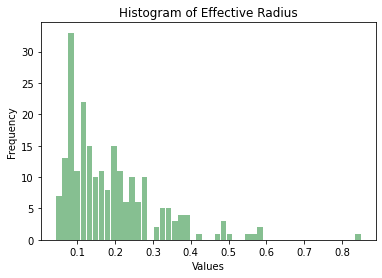

In [45]:
df = pd.read_csv('FJR.csv')
df['VSIGMA_RE'].hist(bins=50, grid=False, color='#86bf91', rwidth=0.9)
plt.title('Histogram of Effective Radius')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()

## Importing Data

Here, we filter out any rows which are missing data for Magnitude `M_r` and velocity dispersion `SIGMA_3_ARCSECOND`.

We may optionally choose to select slow rotators only with `VSIGMA_RE < 0.2`.

In [50]:
df = pd.read_csv('FJR.csv')
df = df[df['VSIGMA_RE'] < 0.3]
df

,CATID,ellip,z_spec,Mstar,M_r,r_e,VSIGMA_RE,VSIGMA_RE_ERR,SIGMA_RE,SIGMA_RE_ERR,TYPE
0,7289,0.2661,0.08682,11.12,-22.370001,4.96,0.079767,0.007218,205.145279,1.877292,0.5
2,7969,0.1772,0.08554,11.02,-22.120001,5.17,0.080168,0.006884,249.797653,2.451845,0.5
4,8865,0.1000,0.07314,10.66,-21.160000,2.50,0.044664,0.009100,214.679764,2.817183,0.0
6,15481,0.0440,0.05407,11.08,-22.230000,5.63,0.076182,0.004937,225.851822,2.282452,0.0
7,16022,0.1207,0.05368,10.41,-20.650000,2.19,0.068877,0.009021,119.587006,1.154839,0.5
...,...,...,...,...,...,...,...,...,...,...,...
237,618937,0.1979,0.05547,10.29,-20.440001,2.74,0.248229,0.013717,115.352158,1.822602,0.5
239,618947,0.2437,0.05592,10.59,-21.040001,2.29,0.198533,0.008310,154.557480,1.459691,0.5
240,619258,0.0775,0.05711,10.07,-19.900000,1.61,0.085919,0.012288,154.294449,2.149503,0.0
241,622350,0.0825,0.08733,11.10,-22.290001,4.89,0.137130,0.010953,204.201096,2.767676,0.0


#### Faber-Jackson Grouped by `r_e`
Here, the Faber-Jackson relation and the residuals are plotted grouped by the galaxy's effective radius `r_e`.

No handles with labels found to put in legend.
No handles with labels found to put in legend.


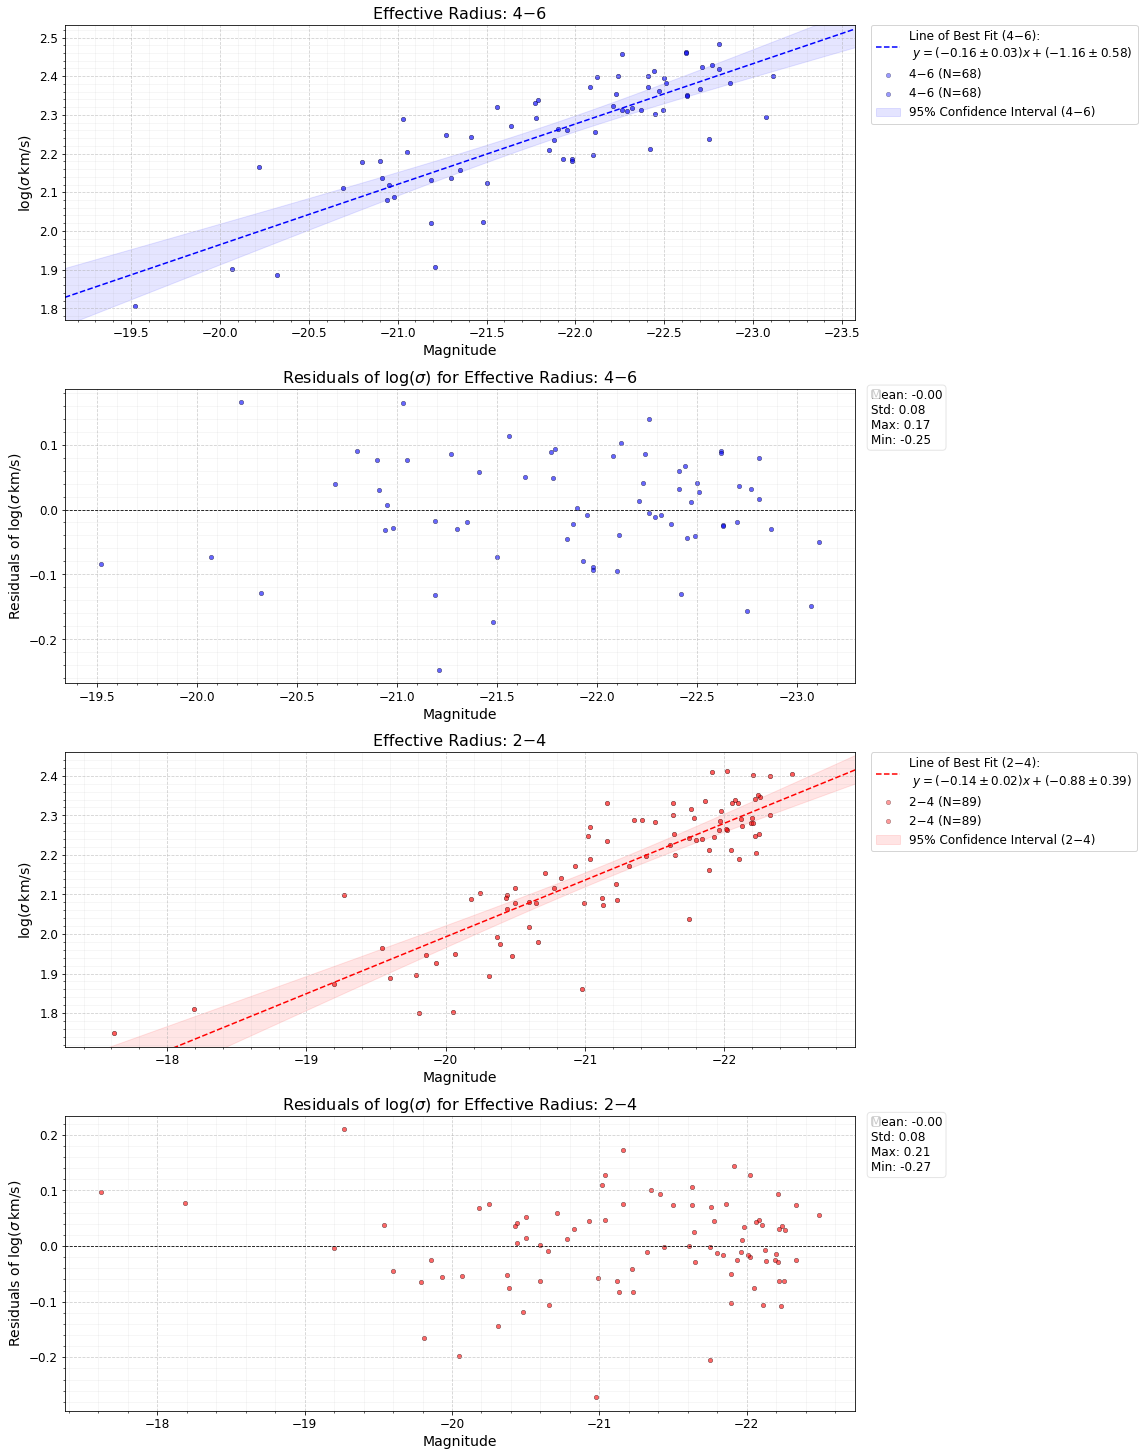

In [59]:
bin_edges = [0, 2, 4, 6, 8, float('inf')]
bin_labels = ['0−2', '2−4', '4−6', '6−8', '>8']
df['r_e_bin'] = pd.cut(df['r_e'], bins=bin_edges, labels=bin_labels, right=False)

x_data = df['M_r']
y_data = np.log10(df['SIGMA_RE'])

colors = ['b', 'r', 'g', 'purple', 'orange']
group_col = df['r_e_bin']
values = group_col.unique()

# Create a figure
fig = plt.figure(figsize=(16, 40))

# Create 6 subplots in a 2x3 grid
subplots_created = 0
for i, value in enumerate(values):
    mask = group_col == value  # This mask is used to filter out certain data to create groups.
    count = sum(mask)
    
    # Only create a subplot if count >= 20
    if count >= 20:
        subplots_created += 1
        ax = fig.add_subplot(2*len(values), 1, subplots_created)
        ax.scatter(x_data[mask], y_data[mask], s=20, color=colors[i], alpha=0.4, edgecolors='k', linewidths=0.5, label=f'{value} (N={count})')
        fit_params = plot_fitlines(x_data[mask], y_data[mask], color=colors[i], label=value, best_fit=True, cinterval=True, residuals=True)
        apply_custom_style(title=f'Effective Radius: {value}', xlabel='Magnitude', ylabel='$\log(\sigma \, \mathrm{ km/s})$', style=1, x_data=x_data[mask], y_data=y_data[mask])
        
        subplots_created += 1
        ax = fig.add_subplot(2*len(values), 1, subplots_created)
        plot_residuals1(x_data[mask], y_data[mask], fit_params)
        apply_custom_style(title=f'Residuals of $\log(\sigma)$ for Effective Radius: {value}', xlabel='Magnitude', ylabel='Residuals of $\log(\sigma \, \mathrm{ km/s})$', style=1)
        
        # Invert x-axis
        if all(x <= 0 for x in x_data):
            plt.gca().invert_xaxis()
            
plt.savefig('plots/FJR_by_RE_and_residuals.png', dpi=300, bbox_inches='tight')
plt.show()

## Faber-Jackson Relation

The Faber-Jackson relation can be expressed as

$$
L \propto \sigma_{0}^{4}
$$

where $\sigma_0$ is the central value for the radial-velocity dispersion, and $L$ is the galaxy's luminosity. By taking the $\log$ of both sides and writing $L$ in terms of solar masses, we can simplify the Faber-Jackson relation as:

$$
\begin{align*}
    L &\propto \sigma_{0}^{4} \\
    \log_{10}\left(\frac{L}{L_☉}\right) &= \log_{10}(\sigma_{0}^4) \\
    M &= a\log_{10}\sigma + b
\end{align*}
$$

where we expect $a=4$ and $b=0$.

There is a discussion to improve the Faber-Jackson relation to produce a tighter relation by introducing the effective radius $r_e$ (see <i>An Introduction to Modern Astrophysics</i>, page 998), giving:

$$
L \propto \sigma_{0}^{2.65}r_{e}^{0.65}
$$

which when written as a function of absolute magnitude $M$, becomes

$$
M = a\log_{10}\sigma + b\log_{10} r_e + c.
$$

A 3D plot featuring a best-fit plane illustrates the predicted of a planar trend.

### 3D Plot of $σ$, $r_e$, and $M_r$. 

#### 3D Plot of the Fundamental Plate
Here, the fundamental plane is plotted. I should double check that this is done correctly, I feel like it hasn't...

<IPython.core.display.Javascript object>


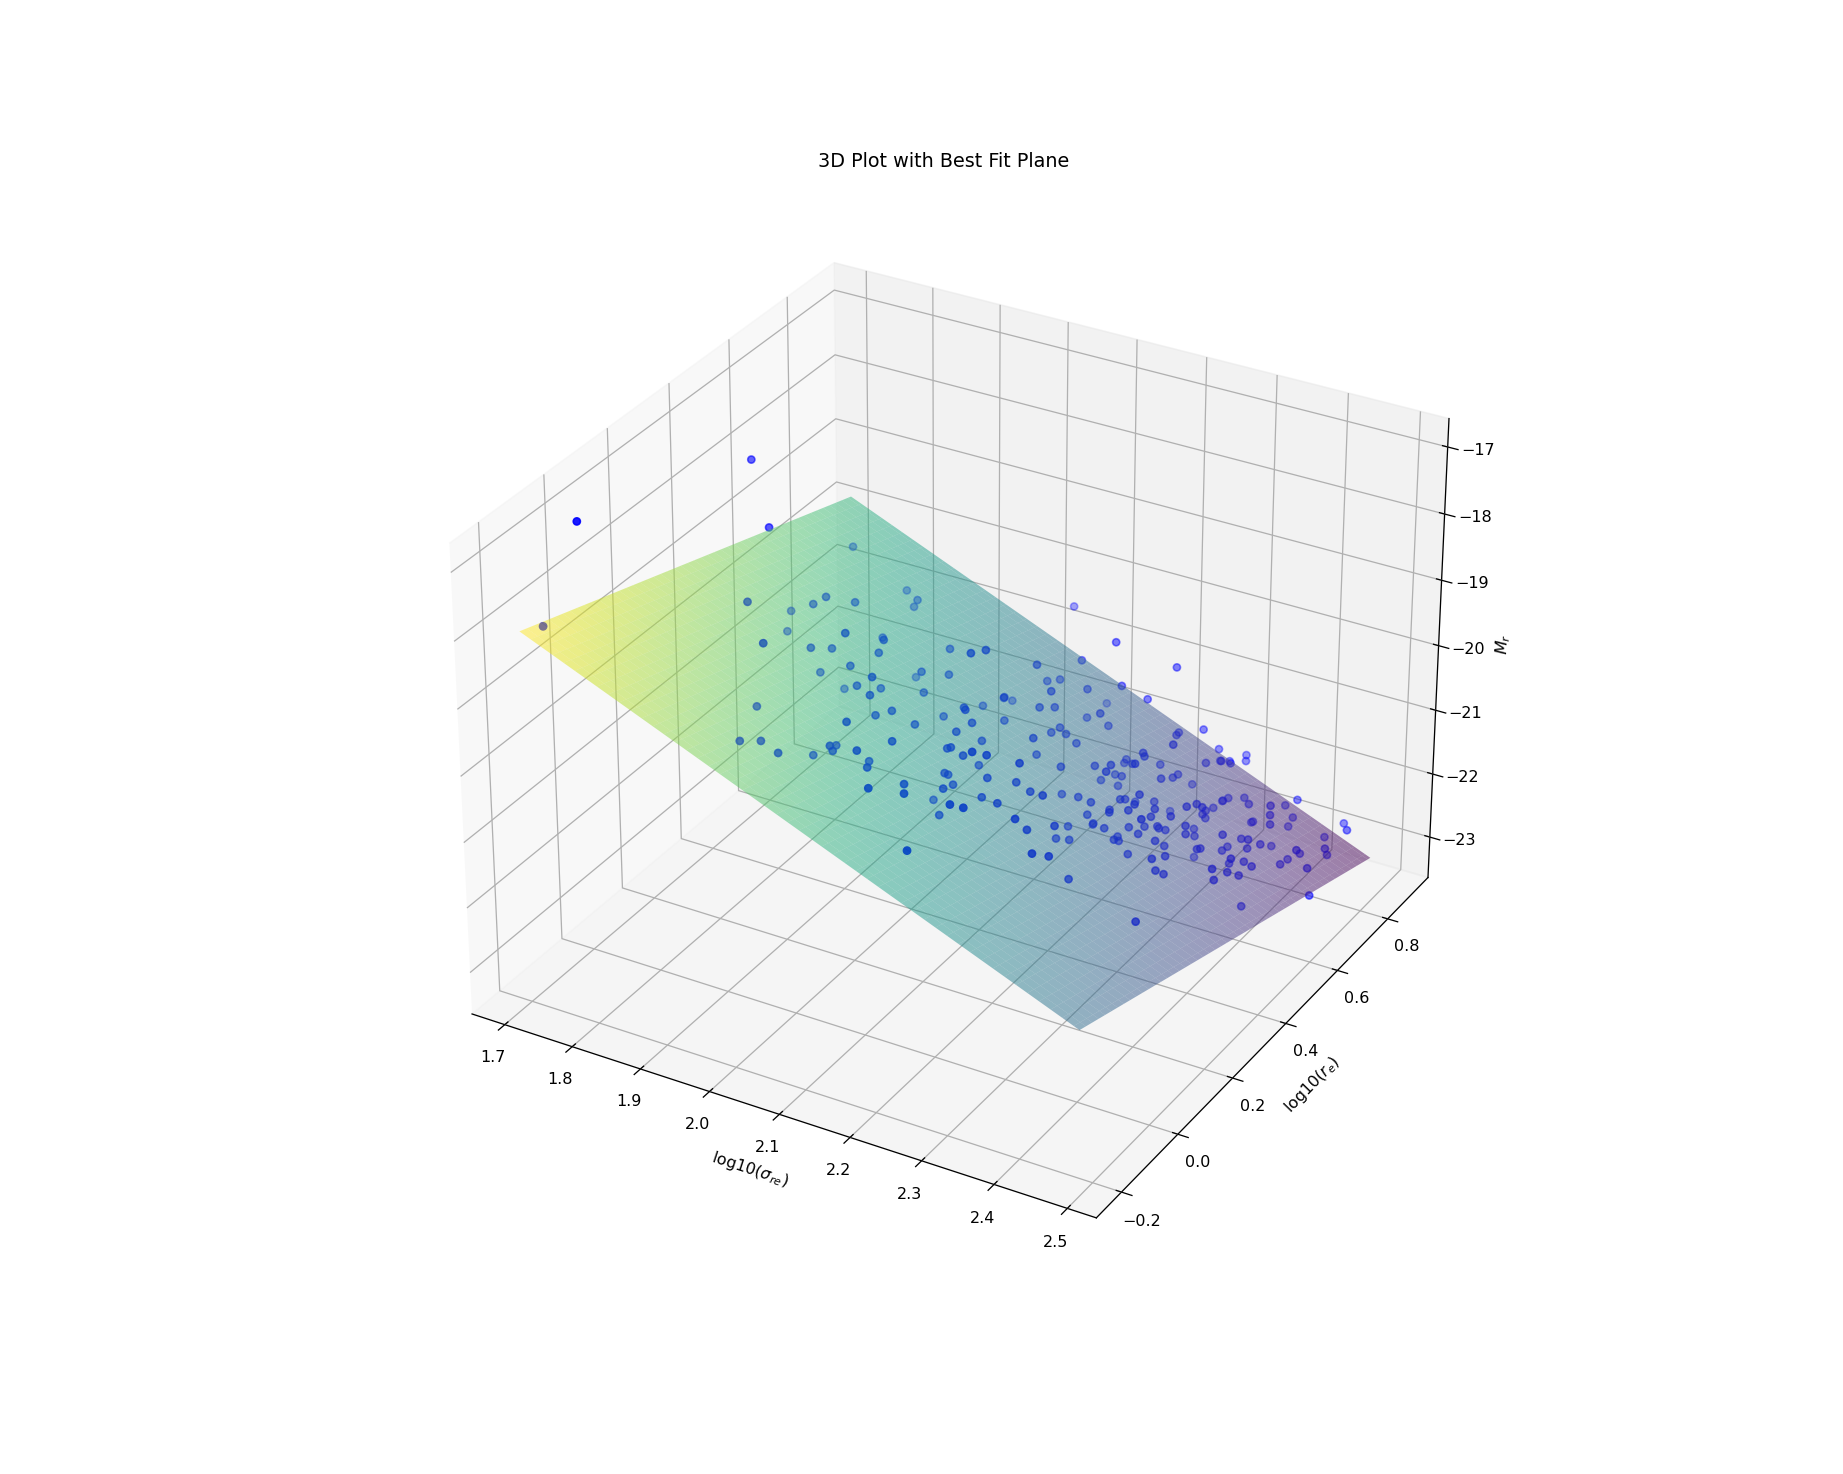

In [66]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import least_squares

%matplotlib notebook
# Replace this with your actual data
x = np.log10(df['SIGMA_RE'])
y = np.log10(df['r_e'])
z = df['M_r']

# Define the function for the plane to fit
def plane(params, x, y, z):
    a, b, c = params
    return a * x + b * y + c - z

# Initial guess for the plane parameters
initial_guess = [1, 1, 1]

# Fit the plane to the data
result = least_squares(plane, initial_guess, args=(x, y, z))

# Extract the fitted plane parameters
a, b, c = result.x

# Create a meshgrid for plotting the plane
x_range = np.linspace(min(x), max(x), 100)
y_range = np.linspace(min(y), max(y), 100)
xx, yy = np.meshgrid(x_range, y_range)
zz = a * xx + b * yy + c

# Create the 3D plot with a larger figure size
fig = plt.figure(figsize=(10, 8))  # You can adjust the width and height as needed
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the data points
ax.scatter(x, y, z, c='b', marker='o', label='Data Points')

# Plot the fitted plane
ax.plot_surface(xx, yy, zz, alpha=0.5, cmap='viridis', label='Fitted Plane')

# Set labels and title
ax.set_xlabel('log10($\sigma_{re}$)')
ax.set_ylabel('log10($r_e$)')
ax.set_zlabel('$M_r$')
ax.set_title('3D Plot with Best Fit Plane')

# Show the plot
plt.show()

In [67]:
%matplotlib inline

We can assess the tightness of this trend by organising the effective radius $(r_e)$ into 2-unit wide bins and calculating the standard deviation of the residuals from the best-fit line. If the relationship is stronger in the enhanced Faber-Jackson relation, we anticipate a smaller standard deviation in the residuals. Any bin containing fewer than 20 counts will be excluded from the plot.

Below, this method is constructed.

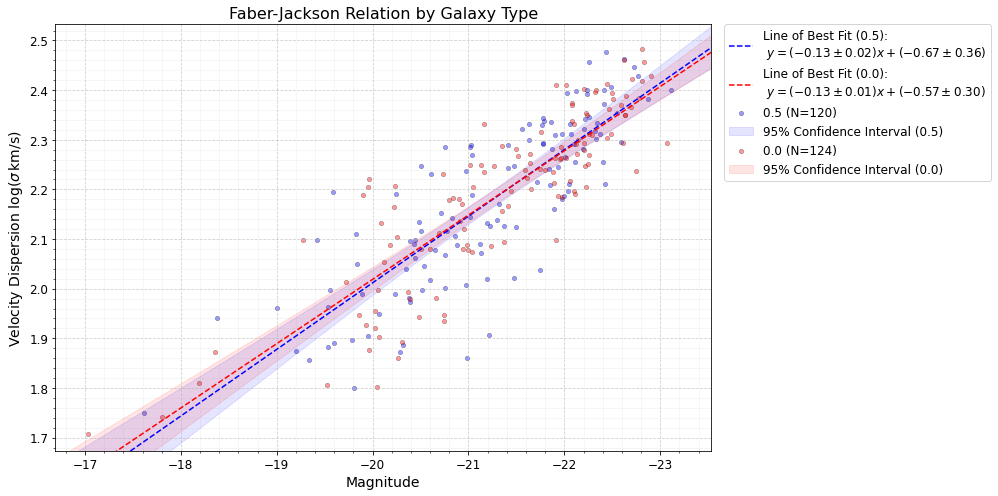

No handles with labels found to put in legend.
No handles with labels found to put in legend.


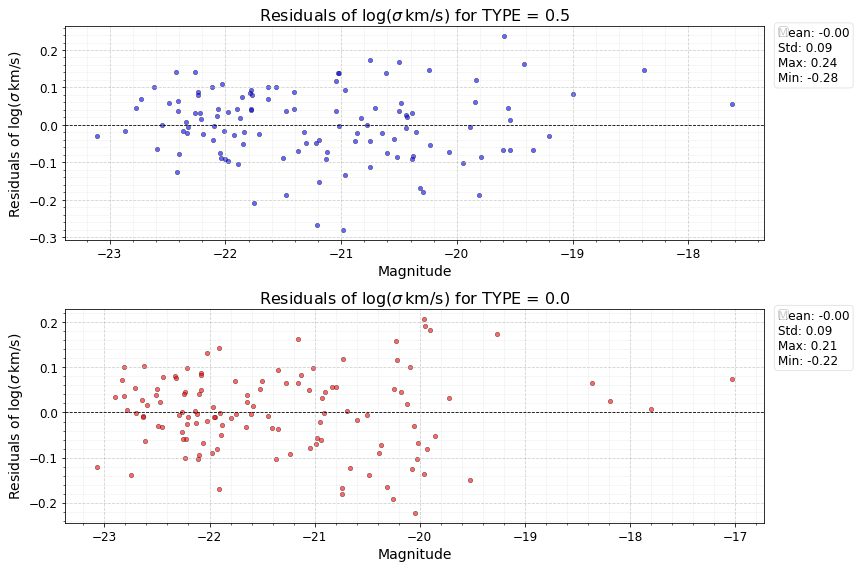

In [71]:
df = pd.read_csv('FJR.csv')

# Initialise features for the graph
x_data = df['M_r']
y_data = np.log10(df['SIGMA_RE'])
title = 'Faber-Jackson Relation'
xlabel = 'Absolute r-band magnitude, $M_r$'
ylabel = 'Log Velocity Dispersion at 3 arcsec aperture, $\log(\sigma / \mathrm{km\ s}^{-1})$'
colors = ['b', 'r', 'g', 'purple', 'orange']

df = clean_df(df, x_data, y_data)  # Clean the DataFrame to ensure no NaN values.

# Choose method to group galaxies. In this case, group by 'TYPE'
group_col = df['TYPE']
values = group_col.unique()

# PLOTTING Faber-Jackson Relation
fig = plt.figure(figsize=(14, 7)) 
ax = fig.add_subplot(1, 1, 1)

fit_params = {}  # Initialise dictionary to store lines of fit parameters. Used to calculate residuals later.
for i, value in enumerate(values):
    mask = group_col == value  # Create a mask to filter data for each group
    fit_param = plot_fitlines(x_data[mask], y_data[mask], color=colors[i], label=value, best_fit=True, cinterval=True, residuals=True)   
    fit_params[value] = fit_param  # Store fit parameters for each group
apply_custom_style(title=f'Faber-Jackson Relation by Galaxy Type', xlabel='Magnitude', ylabel='Velocity Dispersion $\log(\sigma \, \mathrm{ km/s})$', style=1, x_data=x_data[mask], y_data=y_data[mask])

plt.savefig('plots/FJR_by_TYPE.png', dpi=300, bbox_inches='tight')
plt.show()

# PLOTTING Faber-Jackson Relation RESIDUALS
fig = plt.figure(figsize=(12, 8))
for i, value in enumerate(values):
    ax = fig.add_subplot(2, 1, i+1) # Add subplots to the figure
    mask = group_col == value  # Create a mask for each group
    fit_param = fit_params[value]  # Get the fit parameters for the group
    plot_residuals1(x_data[mask], y_data[mask], fit_param)  # Plot residuals for the group
    apply_custom_style(title = f'Residuals of $\log(\sigma \, \mathrm{{ km/s}})$ for TYPE = {value}', xlabel='Magnitude', ylabel='Residuals of $\log(\sigma \, \mathrm{{km/s}})$', style=1)

plt.savefig('plots/FJR_by_TYPE_residuals.png', dpi=300, bbox_inches='tight')
plt.show()


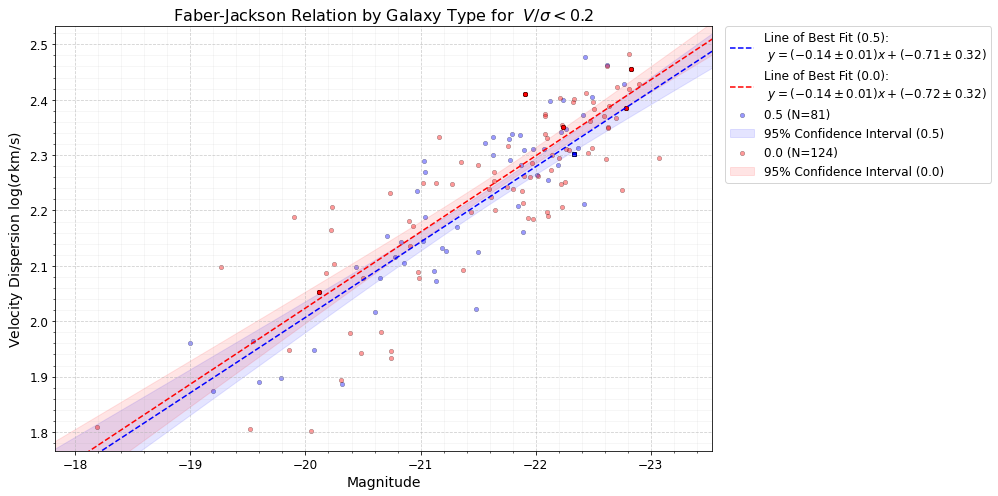

No handles with labels found to put in legend.
No handles with labels found to put in legend.


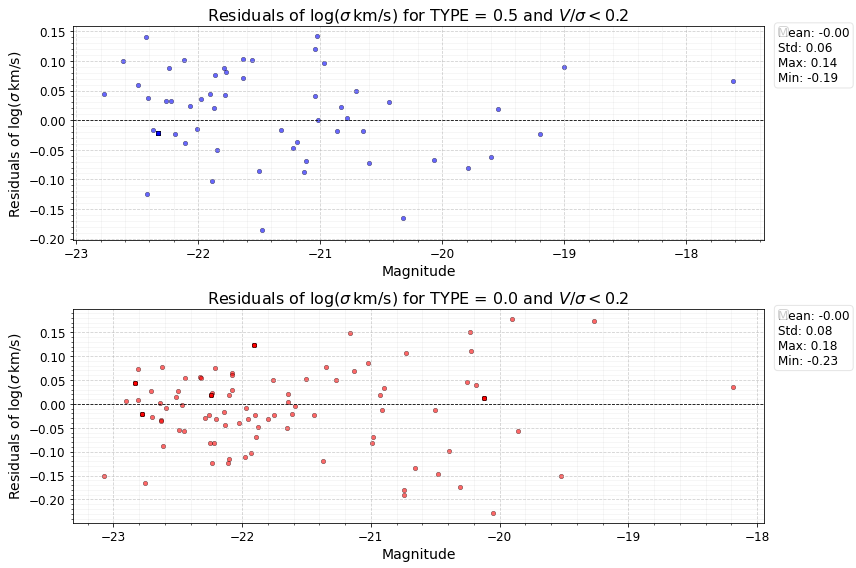

In [75]:
df = pd.read_csv('Query.csv')
df = df[df['VSIGMA_RE'] < 0.2]
df

# Initialise features for the graph
x_data = df['M_r']
y_data = np.log10(df['SIGMA_RE'])
title = 'Faber-Jackson Relation'
xlabel = 'Absolute r-band magnitude, $M_r$'
ylabel = 'Log Velocity Dispersion at 3 arcsec aperture, $\log(\sigma / \mathrm{km\ s}^{-1})$'
colors = ['b', 'r', 'g', 'purple', 'orange']

df = clean_df(df, x_data, y_data)  # Clean the DataFrame to ensure no NaN values.

# Choose method to group galaxies. In this case, group by 'TYPE'
group_col = df['TYPE']
values = group_col.unique()

# PLOTTING Faber-Jackson Relation
fig = plt.figure(figsize=(14, 7)) 
ax = fig.add_subplot(1, 1, 1)

fit_params = {}  # Initialise dictionary to store lines of fit parameters. Used to calculate residuals later.
for i, value in enumerate(values):
    mask = group_col == value  # Create a mask to filter data for each group
    fit_param = plot_fitlines(x_data[mask], y_data[mask], color=colors[i], label=value, best_fit=True, cinterval=True, residuals=True)   
    fit_params[value] = fit_param  # Store fit parameters for each group
apply_custom_style(title=f'Faber-Jackson Relation by Galaxy Type for  $V/\sigma < 0.2$', xlabel='Magnitude', ylabel='Velocity Dispersion $\log(\sigma \, \mathrm{ km/s})$', style=1, x_data=x_data[mask], y_data=y_data[mask])

plt.savefig('plots/FJR_by_TYPE_VSIGMA_0.2.png', dpi=300, bbox_inches='tight')
plt.show()

# PLOTTING Faber-Jackson Relation RESIDUALS
fig = plt.figure(figsize=(12, 8))
for i, value in enumerate(values):
    ax = fig.add_subplot(2, 1, i+1) # Add subplots to the figure
    mask = group_col == value  # Create a mask for each group
    fit_param = fit_params[value]  # Get the fit parameters for the group
    plot_residuals1(x_data[mask], y_data[mask], fit_param)  # Plot residuals for the group
    apply_custom_style(title = f'Residuals of $\log(\sigma \, \mathrm{{ km/s}})$ for TYPE = {value} and $V/\sigma < 0.2$', xlabel='Magnitude', ylabel='Residuals of $\log(\sigma \, \mathrm{{km/s}})$', style=1)

plt.savefig('plots/FJR_by_TYPE_VSIGMA_0.2_residuals.png', dpi=300, bbox_inches='tight')
plt.show()


## MASS v DISPERSION (1)

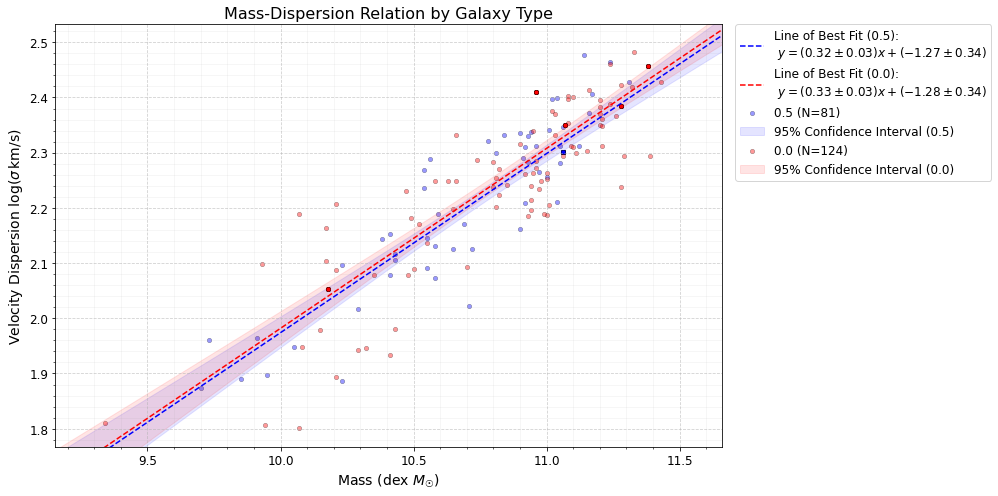

No handles with labels found to put in legend.
No handles with labels found to put in legend.


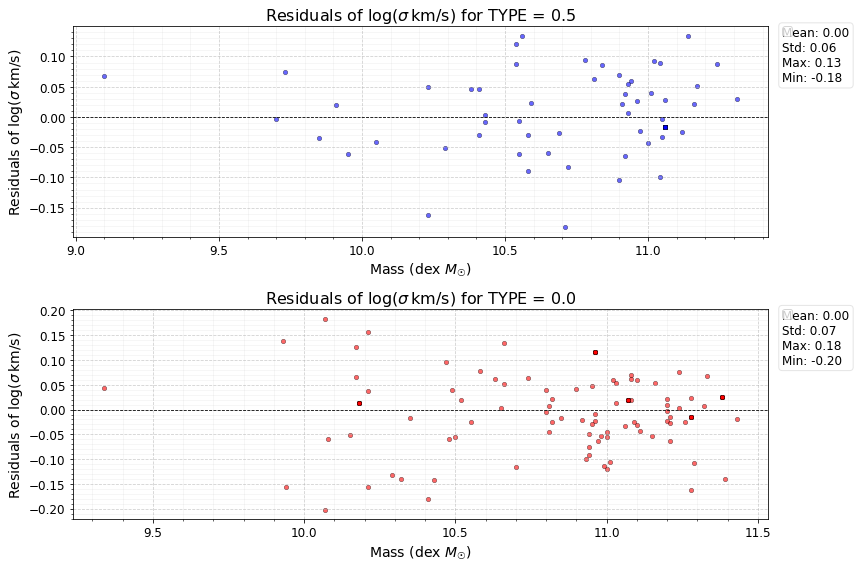

In [77]:
# Initialise features for the graph
x_data = df['Mstar']
y_data = np.log10(df['SIGMA_RE'])
title = 'Mass-Dispersion Relation'
xlabel = 'Mass, $M_star$'
ylabel = 'Log Velocity Dispersion at 3 arcsec aperture, $\log(\sigma / \mathrm{km\ s}^{-1})$'
colors = ['b', 'r', 'g', 'purple', 'orange']

df = clean_df(df, x_data, y_data)  # Clean the DataFrame to ensure no NaN values.

# Choose method to group galaxies. In this case, group by 'TYPE'
group_col = df['TYPE']
values = group_col.unique()

# PLOTTING Relation
fig = plt.figure(figsize=(14, 7)) 
ax = fig.add_subplot(1, 1, 1)

fit_params = {}  # Initialise dictionary to store lines of fit parameters. Used to calculate residuals later.
for i, value in enumerate(values):
    mask = group_col == value  # Create a mask to filter data for each group
    fit_param = plot_fitlines(x_data[mask], y_data[mask], color=colors[i], label=value, best_fit=True, cinterval=True, residuals=True)   
    fit_params[value] = fit_param  # Store fit parameters for each group
apply_custom_style(title=f'Mass-Dispersion Relation by Galaxy Type', xlabel='Mass (dex $M_{☉}$)', ylabel='Velocity Dispersion $\log(\sigma \, \mathrm{ km/s})$', style=1, x_data=x_data[mask], y_data=y_data[mask])

plt.savefig('plots/Mass_Disp.png', dpi=300, bbox_inches='tight')
plt.show()

# PLOTTING Relation RESIDUALS
fig = plt.figure(figsize=(12, 8))
for i, value in enumerate(values):
    ax = fig.add_subplot(2, 1, i+1) # Add subplots to the figure
    mask = group_col == value  # Create a mask for each group
    fit_param = fit_params[value]  # Get the fit parameters for the group
    plot_residuals1(x_data[mask], y_data[mask], fit_param)  # Plot residuals for the group
    apply_custom_style(title=f'Residuals of $\log(\sigma \, \mathrm{{ km/s}})$ for TYPE = {value}', xlabel='Mass (dex $M_{☉}$)', ylabel='Residuals of $\log(\sigma \, \mathrm{ km/s})$', style=1)

plt.savefig('plots/Mass_Disp_residuals.png', dpi=300, bbox_inches='tight')
plt.show()

